# Project for: UC3M Class - Optimization and Decision Analytics
Author: Simon Schmetz

*Required Libraries*
pip install matplotlib networkx


In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import itertools


As the final project for the course "optimization and decision analytics" for the Master in Statistics for  Data Science at the Universidad Carlos III, this project work has the goal to find a optimal distribution of space-train routes between a set of nodes. Between these nodes (each node and each every other node), there is a specific daily amount of demand of unitless "space cargo", that has to be fulfilled on a daily basis. 

To define the demand, we define three types of node: 

- Small nodes
- Medium nodes
- Main nodes

Representing difference smaller and bigger cities/centers and respectively bigger and smaller demands.

In [37]:
### Set up Node number and Position

# Number of nodes
n_nodes = 20

# Create a list for connections
nodes = range(1, n_nodes+1)
routes = [(m, n) for m in nodes for n in nodes if m != n]

# Manually specified positions of nodes 
positions = {
    1: (2, 10),  
    2: (3, 13),
    3: (5, 12),
    4: (6, 15),
    5: (8, 13),   
    6: (8, 9),   
    7: (11, 14),
    8: (13, 12), 
    9: (15, 10),
    10: (11, 9),
    11: (2, 7),
    12: (3, 4),
    13: (5, 7),  
    14: (6, 3),
    15: (8, 5), 
    16: (10, 6),
    17: (11, 6),
    18: (13, 5),
    19: (15, 3),
    20: (17, 5)
}

# Define main & medium nodes
main_nodes = {4, 5, 7, 12, 17}
medium_nodes = {9, 15, 13, 1, 8}

The demand (not yet specified) for each node to every other node is plotted in the following.

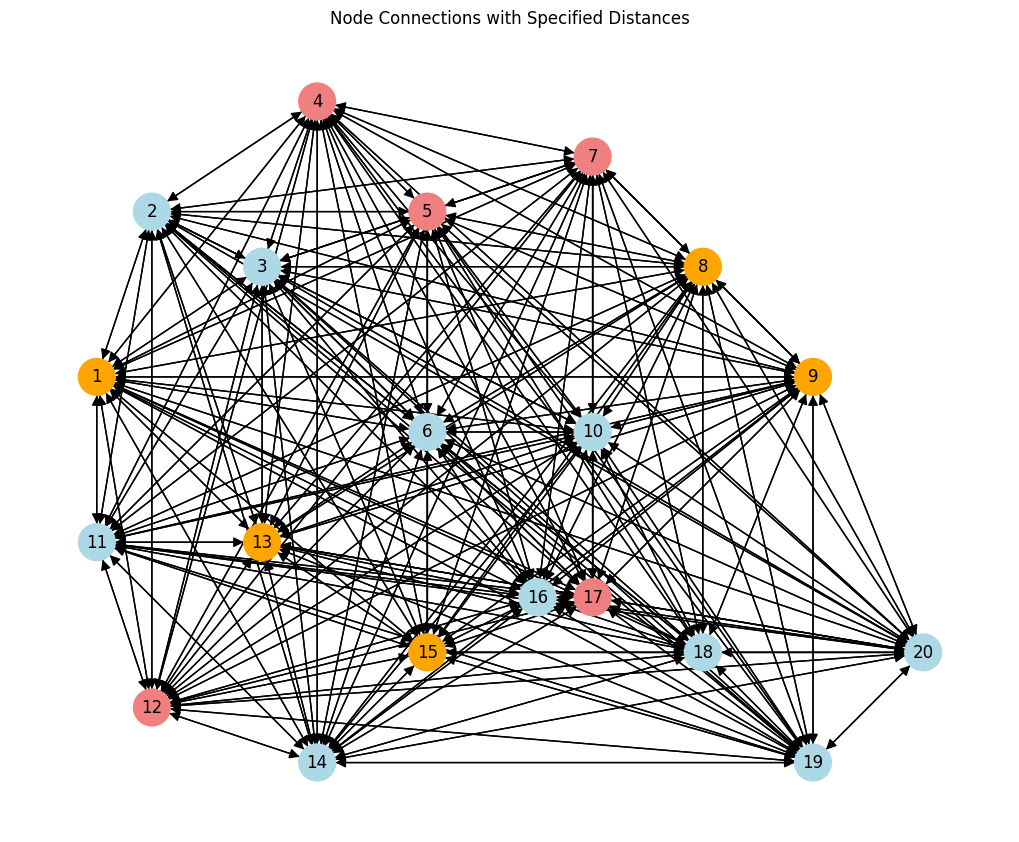

In [38]:
### Plot Node and demands to every other node
# Create a directed graph
G = nx.DiGraph()

# Add edges from the connections list
G.add_edges_from(routes)

# Plot Network
plt.figure(figsize=(10, 8))
node_colors = ['lightcoral' if node in main_nodes else 'orange' if node in medium_nodes else 'lightblue' for node in G.nodes()]
node_color_dict = {node: color for node, color in zip(G.nodes(), node_colors)}

nx.draw(G, pos=positions, with_labels=True, node_size=700, node_color=node_colors, arrowsize=15)
plt.title("Node Connections with Specified Distances")
plt.show()


To generate the demands, values are drawn from a normal distribution and multiplied with constants to account for node type.

In [39]:
### Make Demand

# Create a list of demands (randomly generated for illustration)
demands = [random.randint(200, 400) for _ in range(len(routes))]

# Create a dictionary for connection demands
connections_demand = {}
for connection, demand in zip(routes, demands):
    if connection[0] in main_nodes or connection[1] in main_nodes:
        demand *= 4  # Multiply demand for main nodes
    if connection[0] in medium_nodes or connection[1] in medium_nodes:
        demand *= 2  # Multiply demand for medium nodes
    connections_demand[connection] = demand  # Store connection and its demand in the dictionary

Furthermore, the lines are limited to a given set of routes that represent "space tracks" along which the space trains can move. These are defined as a adjencency Matrix. 

In [40]:
routes = [
    #1 #2 #3 #4 #5 #6 #7 #8 #9 #10#11#12#13#14#15#16#17#18#19#20
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], #1
    [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #2
    [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #3
    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #4
    [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #5
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0], #6
    [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #7
    [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], #8
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1], #9
    [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], #10
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], #11
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0], #12
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0], #13
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0], #14
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], #15
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], #16
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0], #17
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0], #18
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1], #19
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], #20
]

# Function to calculate the Euclidean distance between two points
def euclidean_distance(pos1, pos2):
    return math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)



# Iterate through all pairs of nodes
connections = []
for i in range(len(routes)):
    for j in range(len(routes[i])):
        if routes[i][j] == 1:  # Check for a connection
            connections.append((i + 1, j + 1))  # Add 1 to make it 1-based indexing




To evaluate cost at a later stage in the model_train_number_train_numberling process, the eucledian distances between the connected nodes are collected.

In [42]:
# Create a distance matrix and fill it with NaN where nodes are not connected
n = len(positions)
distance_matrix = np.full((n, n), np.inf)

for i in range(n):
    for j in range(n):
        if routes[i][j] == 1:
            pos_i = positions[i + 1]
            pos_j = positions[j + 1]
            distance_matrix[i][j] = euclidean_distance(pos_i, pos_j)


# Create a new dictionary for edge labels (distances)
edges = {}
for i in nodes:
    for j in nodes:
        if routes[i-1][j-1] == 1:
            edges[(i, j)] = float(round(distance_matrix[i-1][j-1], 2))  # +1 to match 1-indexing



Node connections (arcs) and arc lengths together are shown in the following plot.

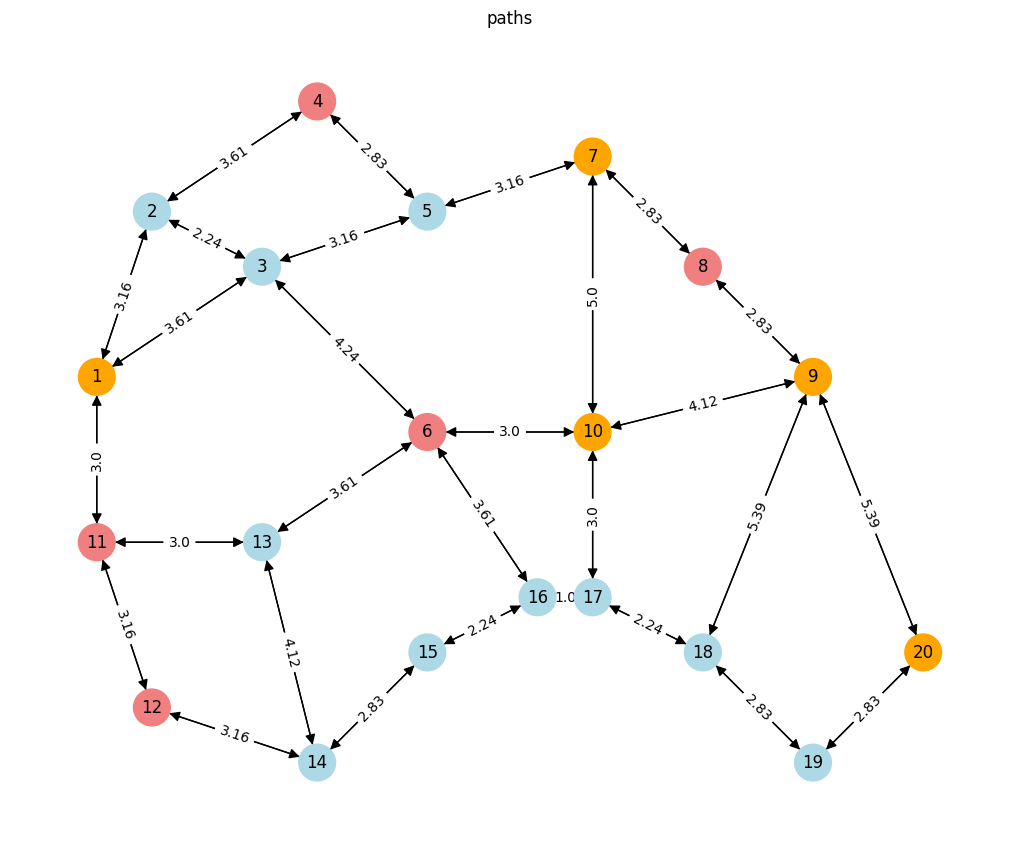

In [43]:
# Plot
G_closest = nx.DiGraph()
G_closest.add_edges_from(connections)

plt.figure(figsize=(10, 8))
nx.draw(G_closest, pos=positions, with_labels=True, node_size=700, node_color=node_colors, arrowsize=15)
nx.draw_networkx_edge_labels(G_closest, pos=positions, edge_labels=edges, font_size=10)

plt.title("paths")
plt.show()

Having established the given system of nodes, their arcs and having generated demands inbetween different nodes - the goal of this project will now be to establish some sort of system for space-train lines that satisfies the maximum possible demand inbetween all nodes. To simplify this fairly complicated problem, as an intitial step, the node-to-node demand will be calculated down to arc demands via repeatetly solving a shortest path problem. This means, that with the assumption that for every node to node demand taking the shortest path between the two will be most efficient, a demmand connecting Node A and Node B will be added to all arcs that are components of the shortest path connecting both node A and B. Doing so will simplify the problem of fullfilling all node to node demands to fullfilling all arc demands. 

## Problem 1 - Shortest Path to generate Arc Demands

As detailed in the setup of the problem, the first part of this project consists of solving $n\times n$ shortest path problems move demands from node to node to respective arcs of the shortest path. In simple terms, this means, to start with all arcs having demand=0, progressively solving shortest path problems inbetween all nodes and adding the demand of inbetween the two nodes to every arc that is part of the shortest path inbetween these two nodes. Doing so, the transport capacity required for each individual arc is calculated assuming all node-to-node demands are fullfilled via their shortest path.

### Mathematical Modelling

The mathematical model consist out of a subjective function that tries to minimize the absolut distance of the shortest path and conditions regarding flow continuity.

The objective function is written as: 
$$
\min \sum_{i,j \in arcs}^{n}c_{i,j}\cdot x_{i,j} \\
$$

with:
- $c_{i,j}$ as the cost, e.g. the eucledian distance between two given nodes´
- $x_{i,j}$ as the decision variable, e.g. whether a given arc is part of the shortest path or not

In addition to the objective function, two types of flow continuity constraints are required. Where the first one garantuees that every flow that enters a node also leaves the same node, with the exception for the start or end node, and the second two respectively covering the cases of start and end nodes where for start nodes only one flow unit can leave the node and none can enter and vice versa for the end node.

$$
\text{s.t.} 
\sum_{i,j \in arcs}^{n} x_{i,j} - \sum_{i,j \in arcs}^{n} x_{j,i} = 0 \text{ if i,j are not start or end node} \\  
\sum_{i,j \in arcs}^{n} x_{start,j} - \sum_{i,j \in arcs}^{n} x_{j,start} = 1\\
\sum_{i,j \in arcs}^{n} x_{i,end} - \sum_{i,j \in arcs}^{n} x_{end,i} = 1\\
$$


### Implementation
This optimization problem with its objective function and the corresponding constraints is implemented in the following piece of code in the form of a methode, to enable running it repeately. 

In [44]:
from pyomo.environ import *

# calculate shortest path function
def shortest_path(model, 
                  source,
                  destination,
                  nodes,
                  arcs,
                  cost,
                  bool_print=False):
    model.source = source
    model.destination = destination

    model.nodes = Set(initialize=nodes) 
    model.arcs = Set(within=model.nodes*model.nodes, initialize=arcs)
    model.cost = Param(model.arcs, initialize=cost)

    model.x = Var(model.arcs, domain=NonNegativeReals)

    # obj function
    def obj_rule(model):
        return sum(model.cost[i, j] * model.x[i, j] for (i, j) in model.arcs)
    model.obj = Objective(rule=obj_rule, sense=minimize)

    # Constraint
    def flow_conservation_rule(model, node):
        if node == model.source:  # Source node
            return (sum(model.x[node, j] for j in model.nodes if (node, j) in model.arcs) - (sum(model.x[i, node] for i in model.nodes if (i, node) in model.arcs))  == 1)
        elif node == model.destination:  # Destination node
            return (sum(model.x[j, node] for j in model.nodes if (j, node) in model.arcs) - sum(model.x[node, i] for i in model.nodes if (node, i) in model.arcs)  == 1)
        else:
            return ((sum(model.x[i, node] for i in model.nodes if (i, node) in model.arcs) == sum(model.x[node, j] for j in model.nodes if (node, j) in model.arcs)))
    model.flow_conservation = Constraint(model.nodes, rule=flow_conservation_rule)

    # Solve 
    solver = SolverFactory('glpk')
    solver.solve(model)

    # Results and plots
    shortest_path_result = {}

    if bool_print: 
        print("length of shortest path: ", value(model.obj))
        print("Shortest Path Route (not sorted):")
        
    for (i, j) in model.arcs:
        if model.x[i, j].value != 0:
            shortest_path_result[(i, j)] = model.x[i, j].value
            if bool_print: 
                print(f"x[{i},{j}]")
        



    return shortest_path_result


The function can be called with the corresponding parameters for any set of nodes and arcs and choosing any source and destination nodes. In the following code chunk, it is called for two nodes and a resulting shortest path is caldulated including a visualization. 

length of shortest path:  14.969999999999999
Shortest Path Route (not sorted):
x[1,3]
x[3,6]
x[6,10]
x[10,9]


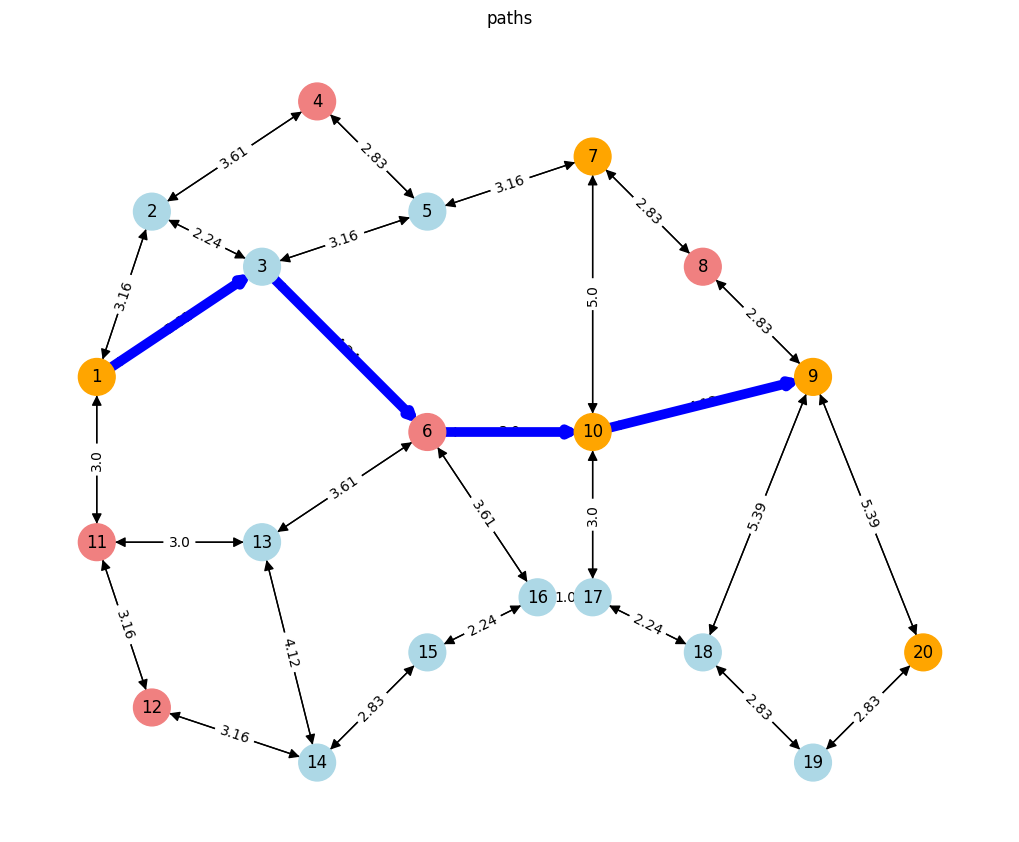

In [45]:

# Call function:
shortest_path_result = shortest_path(
    model = ConcreteModel(),
    source = 1,
    destination = 9,
    nodes= list(positions.keys()),
    arcs = connections,
    cost = edges,
    bool_print=True)


### TODO: Make animation

# Plot
G_closest = nx.DiGraph()
G_closest.add_edges_from(connections)

plt.figure(figsize=(10, 8))
nx.draw(G_closest, pos=positions, with_labels=True, node_size=700, node_color=node_colors, arrowsize=15)
nx.draw_networkx_edge_labels(G_closest, pos=positions, edge_labels=edges, font_size=10)
nx.draw_networkx_edges(G_closest, pos=positions, edgelist=shortest_path_result, edge_color='blue', width=7)

plt.title("paths")
plt.show()

# sensitivity analsysis
# model.dual = Suffix(direction=Suffix.IMPORT)
# print("Sensitivity Analysis",display(model.dual))
# model.pprint()


### Sensitivity Analsysis
TODO

### Solving big Problem 

Having created a method that can be used to solve the shortest path problem, it is then used to solve the bigger optimization problem which is to distribute all node-to-node demands onto the arcs via their shortest connecting path. This is done by iterating over all nodes-to-node demands and adding the respective demands to the arcs of the shortest path connecting two nodes.

In [49]:
### Generate Arc Demands
arc_demand = {key: 0 for key in connections_demand.keys() if key in connections}
# iterate over nodes
for (source,destination) in connections_demand.keys():
    shortest_path_result = shortest_path(
        model = ConcreteModel(),
        source = source,
        destination = destination,
        nodes= list(positions.keys()),
        arcs = connections,
        cost = edges)
        # get results and add to existing demand on arc
    for (node_out,node_in) in shortest_path_result:
        arc_demand[(node_out,node_in)] = arc_demand[(node_out,node_in)] + connections_demand[(source,destination)]



The resuling demands can vizualized as before to show how they are distributed.

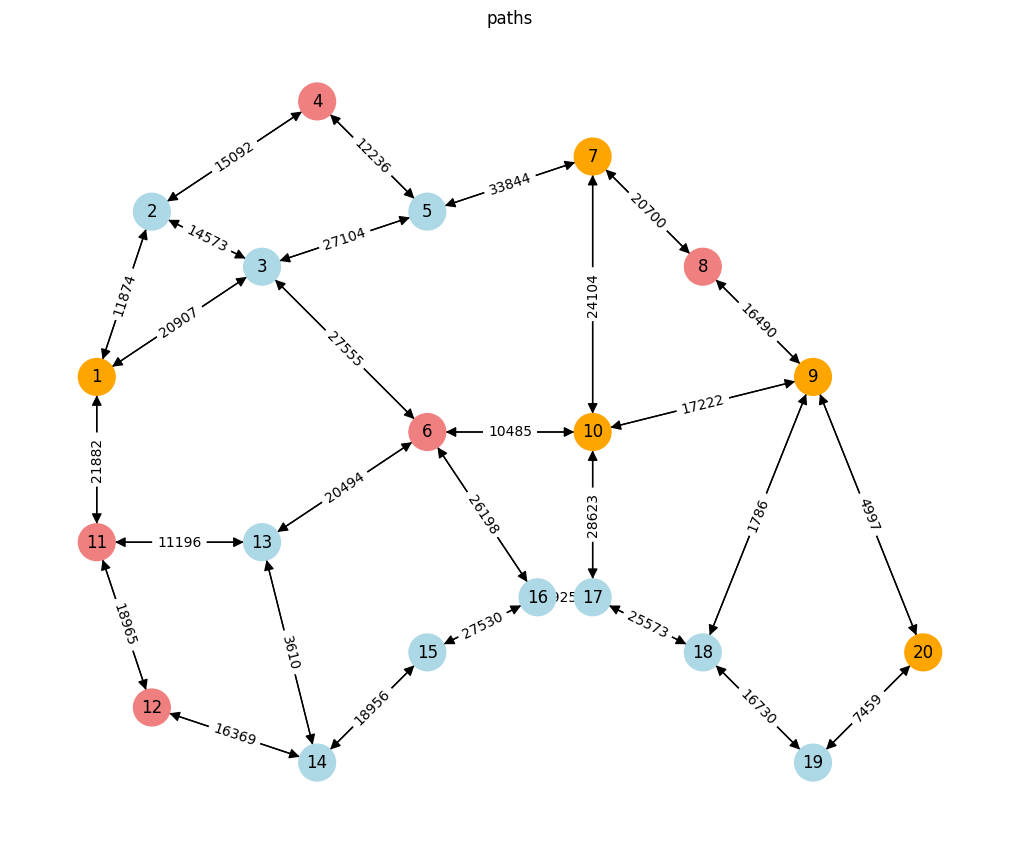

In [51]:
# Plot arc demands 
G_closest = nx.DiGraph()
G_closest.add_edges_from(connections)

plt.figure(figsize=(10, 8))
nx.draw(G_closest, pos=positions, with_labels=True, node_size=700, node_color=node_colors, arrowsize=15)
nx.draw_networkx_edge_labels(G_closest, pos=positions, edge_labels=arc_demand, font_size=10)

plt.title("paths")
plt.show()

# TODO: Make heatmap for demand
# TODO: Demand shown only one way 


# Part 2 - Lines

Problem formulation: 

$min(\sum_{l=1}^{nlines} (fixcost+y_l\cdot costpertrain+\sum_{j=1}^{J}\sum_{i=1}^{I}x_{l;j,i}\cdot costperarc))$

s.t. 

*Demand Constraint:*

$demand_{i,j} \leq \sum_{l=1}^{nlines}y_l\cdot x_{l;j,i}$

*Flow Constraint:*

$\sum_{j:(i,j)}x_{l;i,j}+isstart_{l;i,j}=\sum_{j:(i,j)}x_{l;j,i}*+isend_{l;i,j}$

$\sum_{j:(i,j)}isstart_{l;i,j} = 1$

$\sum_{j:(i,j)}isend_{l;i,j} = 1$


*Max line length constraint*

$\sum_{j=1}^{J}\sum_{i=1}^{I}x_{l;j,i}=7$

### Nonlinear Problem

In [53]:
# # NONLINEAR MODEL

# from pyomo.environ import *

# # Create model
# model_trainlines = ConcreteModel()

# # Sets
# model_trainlines.nodes = Set(initialize=list(positions.keys()))  # Set of nodes
# model_trainlines.arcs = Set(within=model_trainlines.nodes*model_trainlines.nodes, initialize=connections)  # Set of arcs

# # Parameters
# model_trainlines.demand = Param(model_trainlines.arcs, initialize=arc_demand)  # Demand on arcs

# ## lines
# model_trainlines.cost_per_arc = Param(model_trainlines.arcs, initialize=edges)  # Cost of using an arc
# model_trainlines.cost_per_train_line = Param(initialize=400)  # Fixed cost per train line
# model_trainlines.max_lines = Param(initialize=20)  # Maximum possible train lines (upper bound)
# model_trainlines.capacity_per_line = Param(initialize=5000)

# ## trains
# model_trainlines.max_trains_per_line = Param(initialize=15)
# model_trainlines.capacity_per_train = Param(initialize=800)
# model_trainlines.cost_per_train = Param(initialize=100)

# # Decision Variables
# model_trainlines.lines = RangeSet(1, model_trainlines.max_lines)  # Maximum possible number of train lines (upper bound)
# model_trainlines.active_lines = Var(within=NonNegativeIntegers, bounds=(0, model_trainlines.max_lines))  # Number of active train lines
# model_trainlines.x = Var(model_trainlines.lines, model_trainlines.arcs, within=NonNegativeIntegers)  # Binary: Train line t runs on arc (i,j)

# model_trainlines.is_start_node = Var(model_trainlines.lines, nodes, within=Binary)
# model_trainlines.is_end_node = Var(model_trainlines.lines, nodes, within=Binary)


# model_trainlines.range_trains_per_line = RangeSet(1, model_trainlines.max_trains_per_line)
# model_trainlines.active_trains_per_line = Var(model_trainlines.lines,within=NonNegativeIntegers, bounds=(0, model_trainlines.max_trains_per_line))  # Number of active train lines


# # Objective Rule

# def objective_rule_lines(model):
#     cost = model.active_lines * model.cost_per_train_line \
#             + sum(model.cost_per_train * model_trainlines.active_trains_per_line[l] for l in model.lines) \
#            + sum(model.cost_per_arc[i, j] * model.x[l, i, j] for l in model.lines for (i, j) in model.arcs)

#     return cost
# model_trainlines.objective = Objective(rule=objective_rule_lines, sense=minimize)


# # Define the demand constraint for each arc (i, j)
# def demand_constr(model_trainlines, i, j):
#     return model_trainlines.demand[i, j] <= sum(
#         model_trainlines.active_trains_per_line[l] * 
#         model_trainlines.capacity_per_train * model_trainlines.x[l, i, j]
#         for l in model_trainlines.lines
#     ) 
# model_trainlines.demand_constraint = Constraint(model_trainlines.arcs, rule=demand_constr)

# def flow_constr(model_trainlines,l):
#     for node in model_trainlines.nodes:
#         if node == model_trainlines.is_start_node:  # Source node
#             return ((sum(model_trainlines.x[l, i, node] for i in model_trainlines.nodes if (i, node) in model_trainlines.arcs) + sum(model_trainlines.x[l,node, j] for j in model_trainlines.nodes if (node, j) in model_trainlines.arcs)) == 1)
#         elif node == model_trainlines.is_end_node:  # Destination node
#             return ((sum(model_trainlines.x[l, node, i] for i in model_trainlines.nodes if (node, i) in model_trainlines.arcs) + sum(model_trainlines.x[l,j, node] for j in model_trainlines.nodes if (j, node) in model_trainlines.arcs)) == 1)
#         else:
#             return ((sum(model_trainlines.x[l, i, node] for i in model_trainlines.nodes if (i, node) in model_trainlines.arcs) == sum(model_trainlines.x[l,node, j] for j in model_trainlines.nodes if (node, j) in model_trainlines.arcs)))

# model_trainlines.flow_constr = Constraint(model_trainlines.lines, rule=flow_constr)

# def one_start_node_constr(model_trainlines, l):
#     return sum(model_trainlines.is_start_node[l, node] for node in nodes) == 1
# model_trainlines.one_start_node_constr = Constraint(model_trainlines.lines, rule=one_start_node_constr)

# def one_end_node_constr(model_trainlines, l):
#     return sum(model_trainlines.is_end_node[l, node] for node in nodes) == 1
# model_trainlines.one_end_node_constr = Constraint(model_trainlines.lines, rule=one_end_node_constr)

# def max_line_lenght(model_trainlines,l):
#     return (sum(model_trainlines.x[l,i,j] for (i,j) in model_trainlines.arcs)) <= 8
# model_trainlines.line_lenght_constraint = Constraint(model_trainlines.lines, rule=max_line_lenght)


# # Solve 
# solver = SolverFactory('glpk')
# solver.solve(model_trainlines)

## Revised complicated Problem


min c_per_line*n_lines

s.t. 
n_line <= 10

%every node is connected
x[l,node,j] = 1 
x[l,j,node] = 1

% every node next to each other is connected, all arcs are used 

%flow constraint
(...)


if x[l,node,j] == 0 and x[l,i,node] == 1:
node = isendnode
if x[l,node,j] == 1 and x[l,i,node] == 0:
node = isstartnode




In [54]:
# # NONLINEAR MODEL

# from pyomo.environ import *

# # Create model
# model_trainlines = ConcreteModel()

# # Sets
# model_trainlines.nodes = Set(initialize=list(positions.keys()))  # Set of nodes
# model_trainlines.arcs = Set(within=model_trainlines.nodes*model_trainlines.nodes, initialize=connections)  # Set of arcs

# # Parameters
# model_trainlines.demand = Param(model_trainlines.arcs, initialize=arc_demand)  # Demand on arcs

# ## lines
# model_trainlines.cost_per_arc = Param(model_trainlines.arcs, initialize=edges)  # Cost of using an arc
# model_trainlines.cost_per_train_line = Param(initialize=400)  # Fixed cost per train line
# model_trainlines.max_lines = Param(initialize=20)  # Maximum possible train lines (upper bound)
# model_trainlines.capacity_per_line = Param(initialize=5000)


# # Decision Variables
# model_trainlines.lines = RangeSet(1, model_trainlines.max_lines)  # Maximum possible number of train lines (upper bound)
# model_trainlines.active_lines = Var(within=NonNegativeIntegers, bounds=(0, model_trainlines.max_lines))  # Number of active train lines
# model_trainlines.x = Var(model_trainlines.lines, model_trainlines.arcs, within=NonNegativeIntegers)  # Binary: Train line t runs on arc (i,j)

# model_trainlines.is_start_node = Var(model_trainlines.lines, nodes, within=Binary)
# model_trainlines.is_end_node = Var(model_trainlines.lines, nodes, within=Binary)


# model_trainlines.range_trains_per_line = RangeSet(1, model_trainlines.max_trains_per_line)
# model_trainlines.active_trains_per_line = Var(model_trainlines.lines,within=NonNegativeIntegers, bounds=(0, model_trainlines.max_trains_per_line))  # Number of active train lines


# # Objective Rule

# def objective_rule_lines(model):
#     return model_trainlines.cost_per_train_line*model_trainlines.active_lines
# model_trainlines.objective = Objective(rule=objective_rule_lines, sense=minimize)


# # Define the demand constraint for each arc (i, j)
# def demand_constr(model_trainlines, i, j):
    
# model_trainlines.demand_constraint = Constraint(model_trainlines.arcs, rule=demand_constr)

# def flow_constr(model_trainlines,l):
#     for node in model_trainlines.nodes:
#         if node == model_trainlines.is_start_node:  # Source node
#             return ((sum(model_trainlines.x[l, i, node] for i in model_trainlines.nodes if (i, node) in model_trainlines.arcs) + sum(model_trainlines.x[l,node, j] for j in model_trainlines.nodes if (node, j) in model_trainlines.arcs)) == 1)
#         elif node == model_trainlines.is_end_node:  # Destination node
#             return ((sum(model_trainlines.x[l, node, i] for i in model_trainlines.nodes if (node, i) in model_trainlines.arcs) + sum(model_trainlines.x[l,j, node] for j in model_trainlines.nodes if (j, node) in model_trainlines.arcs)) == 1)
#         else:
#             return ((sum(model_trainlines.x[l, i, node] for i in model_trainlines.nodes if (i, node) in model_trainlines.arcs) == sum(model_trainlines.x[l,node, j] for j in model_trainlines.nodes if (node, j) in model_trainlines.arcs)))

# model_trainlines.flow_constr = Constraint(model_trainlines.lines, rule=flow_constr)

# def one_start_node_constr(model_trainlines, l):
#     return sum(model_trainlines.is_start_node[l, node] for node in nodes) == 1
# model_trainlines.one_start_node_constr = Constraint(model_trainlines.lines, rule=one_start_node_constr)

# def one_end_node_constr(model_trainlines, l):
#     return sum(model_trainlines.is_end_node[l, node] for node in nodes) == 1
# model_trainlines.one_end_node_constr = Constraint(model_trainlines.lines, rule=one_end_node_constr)

# def max_line_lenght(model_trainlines,l):
#     return (sum(model_trainlines.x[l,i,j] for (i,j) in model_trainlines.arcs)) <= 8
# model_trainlines.line_lenght_constraint = Constraint(model_trainlines.lines, rule=max_line_lenght)


# # Solve 
# solver = SolverFactory('glpk')
# solver.solve(model_trainlines)

In [55]:
arc_cost = {key: value * 100 for key, value in edges.items()}

### Simplified Problem

In [133]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from pyomo.environ import *

model = ConcreteModel()

# set up network
model.nodes = Set(initialize=list(positions.keys()))  # Set of nodes
model.arcs = Set(within=model.nodes*model.nodes, initialize=connections)  # Set of arcs
model.demand = Param(model.arcs, initialize=arc_demand)  # Demand on arcs

# set up lines (until avail via optimization)
lines = {
    1: [(11,1),(1, 3), (3, 5), (5, 7), (7, 8), (8, 9),(9,20),(20,19)],
    2: [(1, 3), (3, 6), (6, 16), (16, 17), (17, 18), (18, 19)],
    3: [(12,11),(11,1),(1,2),(2,4),(4,5)],
    4: [(11,13),(13,6),(6,10),(10,9)],
    5: [(7,10),(10,17),(17,16),(16,15),(15,14),(14,12)],
    6: [(13,14)],
    7: [(9,18)],
    8: [(2,3)],
}
line_tuples = [(l, i, j) for l in lines for (i, j) in lines[l]]
model.lines = Set(initialize=line_tuples, dimen=3)
model.n_lines = Param(initialize=20)
model.lines_range = RangeSet(1, model.n_lines)


# Trains
train_capacity = 5000
model.capacity_per_train = Param(initialize=train_capacity)
model.max_trains = Param(initialize=20)  
model.x = Var(model.lines_range,within=NonNegativeIntegers, bounds=(0, model.max_trains))  # Number of active train lines

# Aux var to garantuee non negative
model.y = Var(model.arcs, within=NonNegativeReals)

def unmet_demand_constraint(model, i, j):
    return model.y[i, j] >= model.demand[i, j] - sum(model.capacity_per_train * model.x[l] for l in model.lines_range if (l, i, j) in model.lines) 
model.unmet_demand_constraint = Constraint(model.arcs, rule=unmet_demand_constraint)

# demand constraint for other direction
def unmet_demand_constraint_reverse(model, j, i):
    return model.y[i, j] >= model.demand[j, i] - sum(model.capacity_per_train * model.x[l] for l in model.lines_range if (l, i, j) in model.lines) 
model.unmet_demand_constraint_reverse = Constraint(model.arcs, rule=unmet_demand_constraint_reverse)

def objective_rule_lines(model):
    return sum(model.y[i, j] for (i, j) in model.arcs)
model.objective = Objective(rule=objective_rule_lines, sense=minimize)

# Solve the model
solver = SolverFactory('glpk')
#solver.solve(model, tee=True)
solver.solve(model)

# Display the set to verify
#model.pprint()
for l in model.lines_range:
    if model.x[l].value is not None:
        print(f"Line {l} has {value(model.x[l])} active trains.")

Line 1 has 7.0 active trains.
Line 2 has 8.0 active trains.
Line 3 has 4.0 active trains.
Line 4 has 5.0 active trains.
Line 5 has 8.0 active trains.
Line 6 has 1.0 active trains.
Line 7 has 1.0 active trains.
Line 8 has 3.0 active trains.


In [151]:
arc_capacity = {}
for (i, j) in model.arcs:
    total_capacity = 0
    for l in model.lines_range:
        if (l, i, j) in model.lines:
            total_capacity = total_capacity+ value(model.x[l]) * model.capacity_per_train
    arc_capacity[(i, j)] = total_capacity

for (i,j) in list(arc_capacity.keys()):
    if arc_capacity[(i,j)] == 0:
        arc_capacity[(i, j)] = arc_capacity[(j,i)]

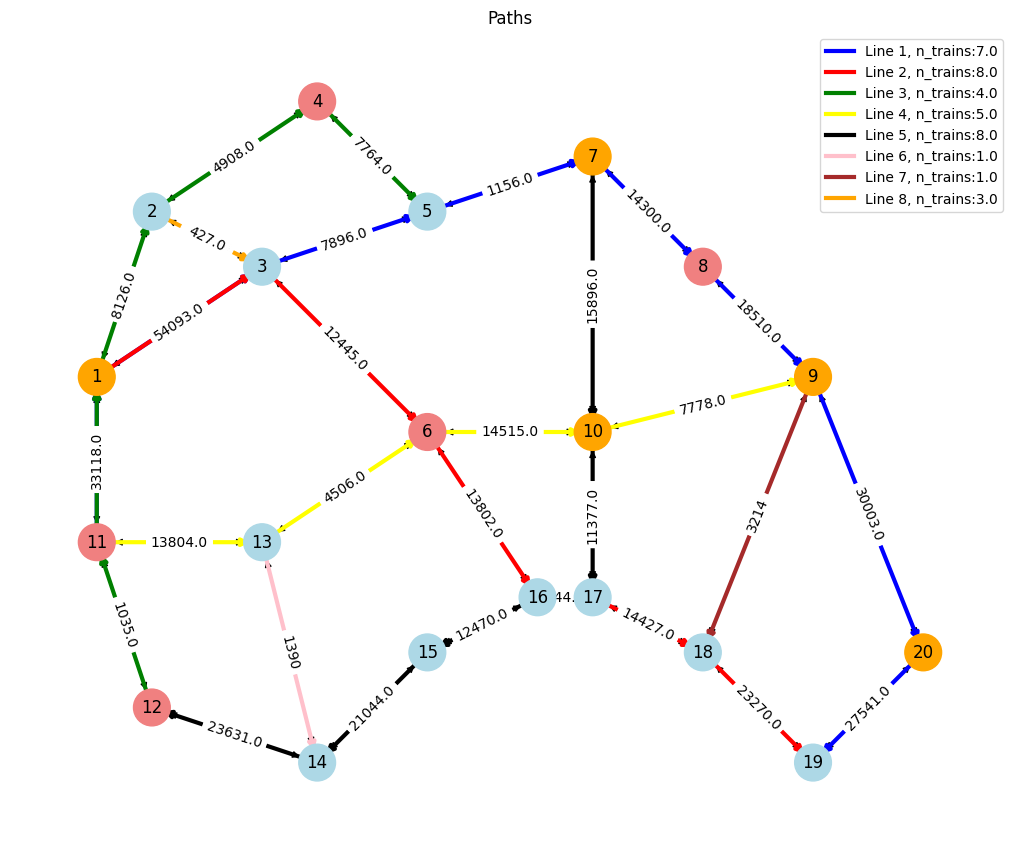

In [160]:
line_colors = {
    1: 'blue', 
    2: 'red', 
    3: 'green',
    4: 'yellow',
    5: 'black',
    6: 'pink',
    7: 'brown',
    8: 'orange'
}

test = 'abc'
edge_labels = {(i, j): f"{arc_capacity[(i,j)] - arc_demand[(i,j)]}" for (i,j) in connections}

G_closest = nx.DiGraph()
G_closest.add_edges_from(connections) 

plt.figure(figsize=(10, 8))
nx.draw(G_closest, pos=positions, with_labels=True, node_size=700, node_color=node_colors)  

for line, edges in lines.items():
    nx.draw_networkx_edges(G_closest, pos=positions, edgelist=edges, edge_color=line_colors[line], width=3)

nx.draw_networkx_edge_labels(G_closest, pos=positions, edge_labels=edge_labels, font_size=10)

# Create legend entries
legend_elements = [Line2D([0], [0], color=color, lw=3, label=f'Line {line}, n_trains:{model.x[line].value}') for line, color in line_colors.items()]
plt.legend(handles=legend_elements, loc='best')


plt.title("Paths")
plt.show()

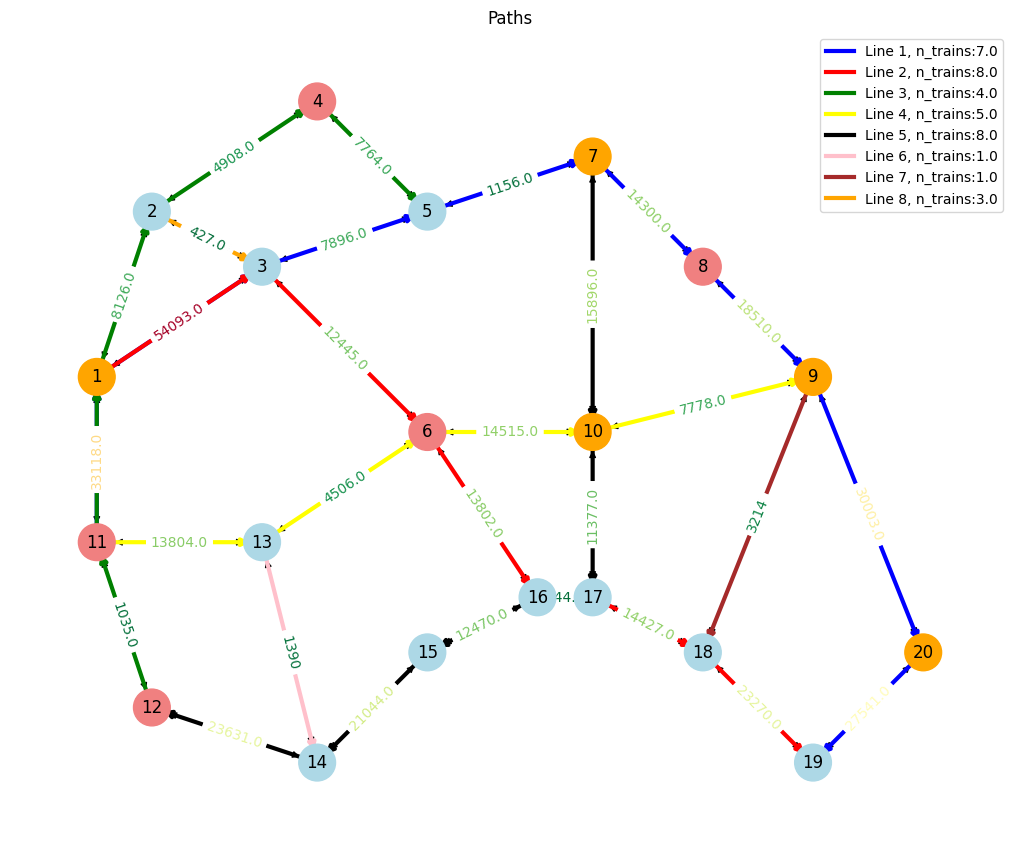

In [162]:
import matplotlib.cm as cm
import numpy as np

# Compute edge values
edge_values = np.array(list(edge_labels.values()), dtype=float)
# Normalize the values to [0, 1]
norm = (edge_values - edge_values.min()) / (edge_values.max() - edge_values.min())
# Create a color map from green (low) to red (high)
cmap = cm.RdYlGn_r  # This colormap goes from red to green

# Create a dictionary to hold colored edge labels
edge_label_colors = {edge: cmap(norm[i]) for i, edge in enumerate(edge_labels.keys())}

plt.figure(figsize=(10, 8))
nx.draw(G_closest, pos=positions, with_labels=True, node_size=700, node_color=node_colors)  

for line, edges in lines.items():
    nx.draw_networkx_edges(G_closest, pos=positions, edgelist=edges, edge_color=line_colors[line], width=3)

# Draw edge labels with corresponding colors
for edge, color in edge_label_colors.items():
    nx.draw_networkx_edge_labels(G_closest, pos=positions, edge_labels={edge: edge_labels[edge]}, font_size=10, 
                                   font_color=color)

# Create legend entries
legend_elements = [Line2D([0], [0], color=color, lw=3, label=f'Line {line}, n_trains:{model.x[line].value}') for line, color in line_colors.items()]
plt.legend(handles=legend_elements, loc='best')

plt.title("Paths")
plt.axis('off')  # Optional: turn off the axis for better aesthetics
plt.show()


In [61]:
from pyomo.environ import *

# Create model
model = ConcreteModel()

# Sets
model.nodes = Set(initialize=list(positions.keys()))  # Set of nodes
model.arcs = Set(within=model.nodes*model.nodes, initialize=connections)  # Set of arcs
model.max_T = Param(initialize=10)  # Maximum possible train lines (upper bound)

# Parameters
model.d = Param(model.arcs, initialize=arc_demand)  # Demand on arcs
model.c = Param(model.arcs, initialize=edges)  # Cost of using an arc
model.capacity_per_arc = Param(model.arcs, initialize=arc_demand)  # Total capacity of an arc
model.cost_per_train_line = Param(initialize=400)  # Fixed cost per train line

# Decision Variables
model.T = RangeSet(1, model.max_T)  # Maximum possible number of train lines (upper bound)
model.x = Var(model.T, model.arcs, within=Binary)  # Binary: Train line t runs on arc (i,j)
model.f = Var(model.T, model.arcs, within=NonNegativeReals)  # Flow on arc (i,j) for train line t
model.num_lines = Var(within=NonNegativeIntegers, bounds=(0, model.max_T))  # Number of active train lines

# Objective: Minimize total cost, including the cost of train lines and the cost of arcs
def objective_rule(model):
    return model.num_lines * model.cost_per_train_line + \
           sum(model.c[i,j] * model.x[t,i,j] for t in model.T for (i,j) in model.arcs)
model.objective = Objective(rule=objective_rule, sense=minimize)

# Constraint: Ensure that the number of active train lines doesn't exceed the model.num_lines
def train_line_count_rule(model, t):
    return sum(model.x[t,i,j] for (i,j) in model.arcs) <= model.num_lines
model.train_line_count = Constraint(model.T, rule=train_line_count_rule)


# Flow conservation constraints for each train line at each node
def flow_conservation_rule(model, t, i):
    return sum(model.f[t,i,j] for j in model.nodes if (i,j) in model.arcs) - \
           sum(model.f[t,j,i] for j in model.nodes if (j,i) in model.arcs) == 0
model.flow_conservation = Constraint(model.T, model.nodes, rule=flow_conservation_rule)

# Demand satisfaction on each arc for each train line
def demand_satisfaction_rule(model, t, i, j):
    return model.f[t,i,j] <= model.d[i,j] * model.x[t,i,j]
model.demand_satisfaction = Constraint(model.T, model.arcs, rule=demand_satisfaction_rule)

# # Capacity constraint: Sum of flows across all train lines cannot exceed total arc capacity
# def capacity_constraint_rule(model, i, j):
#     return sum(model.f[t,i,j] for t in model.T) <= model.capacity_per_arc[i,j]
# model.capacity_constraint = Constraint(model.arcs, rule=capacity_constraint_rule)

  

# Solve the model
solver = SolverFactory('glpk')
solver.solve(model)

# Extract solution: number of train lines and their routes
train_routes = {}
for t in model.T:
    if t <= model.num_lines.value:
        train_routes[t] = [(i, j) for (i, j) in model.arcs if model.x[t, i, j].value == 1]

# Example usage: printing the optimized number of lines and routes
print(f"Optimized number of train lines: {model.num_lines.value}")
for t in train_routes:
    print(f"Train line {t} follows the route: {train_routes[t]}")


ERROR: Rule failed for Param 'c' with index 0: KeyError: "Index '0' is not
valid for indexed component 'c'"


ERROR: Constructing component 'c' from data=None failed:
        KeyError: "Index '0' is not valid for indexed component 'c'"


KeyError: "Index '0' is not valid for indexed component 'c'"

In [ ]:
from pyomo.environ import *

# Create model
model = ConcreteModel()

# Sets
model.nodes = Set(initialize=nodes)  # Set of nodes
model.arcs = Set(within=model.nodes*model.nodes, initialize=arcs)  # Set of arcs
model.T = Set(initialize=train_lines)  # Set of train lines

# Parameters
model.d = Param(model.arcs, initialize=demand)  # Demand on arcs
model.c = Param(model.arcs, initialize=cost)  # Cost of using an arc for a train line
model.capacity_per_arc = Param(model.arcs, initialize=capacity_per_arc)  # Total capacity of an arc

# Decision Variables
model.x = Var(model.T, model.arcs, within=Binary)  # Binary: Train line t runs on arc (i,j)
model.f = Var(model.T, model.arcs, within=NonNegativeReals)  # Flow on arc (i,j) for train line t

# Objective: Minimize the total cost of running the train lines on the network
def objective_rule(model):
    return sum(model.c[i,j] * model.x[t,i,j] for t in model.T for (i,j) in model.arcs)
model.objective = Objective(rule=objective_rule, sense=minimize)

# Flow conservation constraints for each train line at each node
def flow_conservation_rule(model, t, i):
    return sum(model.f[t,i,j] for j in model.nodes if (i,j) in model.arcs) - \
           sum(model.f[t,j,i] for j in model.nodes if (j,i) in model.arcs) == 0
model.flow_conservation = Constraint(model.T, model.nodes, rule=flow_conservation_rule)

# Demand satisfaction on each arc for each train line
def demand_satisfaction_rule(model, t, i, j):
    return model.f[t,i,j] <= model.d[i,j] * model.x[t,i,j]
model.demand_satisfaction = Constraint(model.T, model.arcs, rule=demand_satisfaction_rule)

# Capacity constraint: Sum of flows across all train lines cannot exceed total arc capacity
def capacity_constraint_rule(model, i, j):
    return sum(model.f[t,i,j] for t in model.T) <= model.capacity_per_arc[i,j]
model.capacity_constraint = Constraint(model.arcs, rule=capacity_constraint_rule)

# Solve the model
solver = SolverFactory('glpk')
solver.solve(model)

# Extract solution: individual train lines and their routes
train_routes = {}
for t in model.T:
    train_routes[t] = [(i, j) for (i, j) in model.arcs if model.x[t, i, j].value == 1]

# Example usage: printing routes
for t in train_routes:
    print(f"Train line {t} follows the route: {train_routes[t]}")


# Spielwiese

In [12]:
from pyomo.environ import *

model_lines = ConcreteModel()

# Define sets
# model_lines.N = Set(initialize=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
# model_lines.A = Set(initialize=[(1, 2), (1, 3), ...])  # Add all arcs here

model_lines.nodes = Set(initialize=list(positions.keys())) 
model_lines.arcs = Set(within=model_lines.nodes*model_lines.nodes, initialize=connections)
model_lines.cost = Param(model_lines.arcs, initialize=edges)

# Define parameters
model_lines.demand = Param(model_lines.nodes, arc_demand)  # Demand for each arc
model_lines.fixed_cost = Param(model_lines.nodes, arc_demand)  # Fixed costs for each arc
model_lines.capacity = Param(initialize=1000)

# Decision variables
model_lines.x = Var(model_lines.nodes, within=Binary)  # Whether the line is established
model_lines.y = Var(model_lines.nodes, within=NonNegativeReals)  # Demand transported

# Objective function
model_lines.obj = Objective(expr=sum(model_lines.fixed_cost[i, j] * model_lines.x[i, j] for (i, j) in model_lines.nodes), sense=minimize)

# Constraints
model_lines.demand_constraint = ConstraintList()
for (i, j) in model_lines.nodes:
    model_lines.demand_constraint.add(model_lines.y[i, j] <= model_lines.demand[i, j] * model_lines.x[i, j])
    model_lines.demand_constraint.add(model_lines.y[i, j] <= model_lines.capacity * model_lines.x[i, j])

# Solve the model
solver = SolverFactory('glpk')  # or any other solver
solver.solve(model_lines)

# Display results
model_lines.display()


TypeError: cannot unpack non-iterable int object

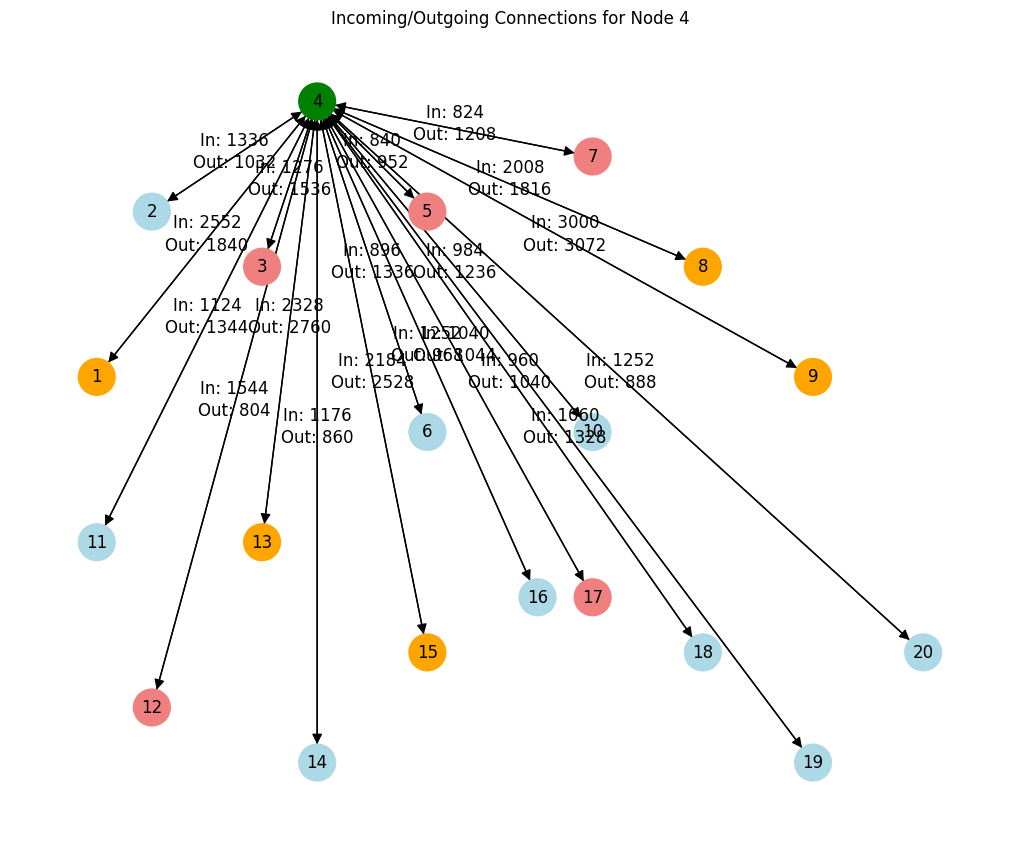

In [153]:

def plot_node_connections(node):
    """Plots incoming and outgoing connections for a specified node."""
    incoming_edges = G.in_edges(node)
    outgoing_edges = G.out_edges(node)
    
    # Filter connections and their demands for the specified node
    filtered_edges = list(incoming_edges) + list(outgoing_edges)
    filtered_demands = [demand_dict[edge] for edge in filtered_edges]

    # Create a new graph for the filtered edges
    H = nx.DiGraph()
    H.add_edges_from(filtered_edges)

    # Create a new positions dictionary
    filtered_positions = {node: positions[node]}  # Position of the specified node
    for edge in filtered_edges:
        filtered_positions[edge[0]] = positions[edge[0]]
        filtered_positions[edge[1]] = positions[edge[1]]

    # Plot the graph with the filtered connections
    plt.figure(figsize=(10, 8))

    # Highlight the central node
    central_node_color = 'green'  # Color for the central node
    node_colors[list(H.nodes()).index(node)] = central_node_color
    nx.draw(H, pos=filtered_positions, with_labels=True, node_size=700, node_color=node_colors, arrowsize=15)
    plt.title(f"Incoming/Outgoing Connections for Node {node}")
    
   # Display demands on the plot
    for edge, demand in zip(incoming_edges, filtered_demands[:len(incoming_edges)]):
        x_start, y_start = filtered_positions[edge[0]]
        x_end, y_end = filtered_positions[edge[1]]
        plt.text((x_start + x_end) / 2, (y_start + y_end) / 2 + 0.2, f"In: {demand}", fontsize=12, color='black', ha='center')
    
    for edge, demand in zip(outgoing_edges, filtered_demands[len(incoming_edges):]):
        x_start, y_start = filtered_positions[edge[0]]
        x_end, y_end = filtered_positions[edge[1]]
        plt.text((x_start + x_end) / 2, (y_start + y_end) / 2 - 0.2, f"Out: {demand}", fontsize=12, color='black', ha='center')

    plt.show()

# Example: Plot connections for node 'n_4'
plot_node_connections(4)

# optimization

## Archive

In [ ]:
from pyomo.environ import *

# Define a model
model = ConcreteModel()

# Set of nodes and arcs (edges) with associated costs
nodes = [1, 2, 3, 4, 5,6,7,8]  # Example set of nodes
arcs = [(1, 2), (1, 3), (2, 4), (3, 4), (4, 5),(5, 6),(6, 7),(7, 8)]  # Edges
costs = {(1, 2): 1, (1, 3): 2, (2, 4): 2, (3, 4): 1, (4, 5): 3,(5, 6):1,(6, 7):2,(7, 8):3}

node_start = 1
node_end = 7

# Parameters
model.nodes = Set(initialize=nodes)
model.arcs = Set(within=model.nodes*model.nodes, initialize=arcs)
model.cost = Param(model.arcs, initialize=costs)

# Decision variables: Flow along arcs (x_ij)
model.x = Var(model.arcs, domain=NonNegativeReals)

# Objective: Minimize total cost along the path
def obj_rule(model):
    return sum(model.cost[i, j] * model.x[i, j] for (i, j) in model.arcs)
model.obj = Objective(rule=obj_rule, sense=minimize)

# Constraints:
# 1. Flow conservation: Flow in = Flow out, except for source and destination
def flow_conservation_rule(model, node):
    if node == 1:  # Source node
        return sum(model.x[i, j] for (i, j) in model.arcs if i == node) == 1
    elif node == 7:  # Destination node
        return sum(model.x[i, j] for (i, j) in model.arcs if j == node) == 1
    else:  # Intermediate nodes
        return (sum(model.x[i, j] for (i, j) in model.arcs if i == node) 
                == sum(model.x[i, j] for (i, j) in model.arcs if j == node))
model.flow_conservation = Constraint(model.nodes, rule=flow_conservation_rule)

# Solve
SolverFactory('glpk').solve(model)

# Display the solution
model.x.display()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Number of nodes
n_nodes = 20

# Create a list for connections
nodes = range(n_nodes)
connections = [(m,n) for m in range(n_nodes) for n in range(n_nodes) if m != n]

# Create a directed graph
G = nx.DiGraph()

# Add edges from the connections list
G.add_edges_from(connections)

# Manually specify positions of nodes (coordinates reflect their distance)
positions = {
    'n_0': (2, 10),
    'n_1': (3, 13),
    'n_2': (5, 12),
    'n_3': (6, 15),
    'n_4': (8, 13),  # Main node
    'n_5': (8, 9),   # Main node
    'n_6': (11, 14),
    'n_7': (13, 12), # Main node
    'n_8': (15, 10),
    'n_9': (11, 9),
    'n_10': (2, 7),
    'n_11': (3, 4),
    'n_12': (5, 7),  # Main node
    'n_13': (6, 3),
    'n_14': (8, 5),
    'n_15': (10, 6),
    'n_16': (11, 6),
    'n_17': (13, 5), # Main node
    'n_18': (15, 3),
    'n_19': (17, 5)
}

# Create a list of demands (randomly generated for illustration)
demands = [random.randint(200, 400) for _ in range(len(connections))]

# Define main nodes that have 4 times demand
main_nodes = {'n_4', 'n_5', 'n_7', 'n_12', 'n_17'}
medium_nodes = {'n_9','n_15','n_13','n_0','n_8'}


# Pair each connection with a demand, adjusting for main and medium nodes
connection_demands = []
for connection, demand in zip(connections, demands):
    if connection[0] in main_nodes or connection[1] in main_nodes:
        demand *= 4  # Double the demand for connections involving main nodes
    if connection[0] in medium_nodes or connection[1] in medium_nodes:
        demand *= 2  # Double the demand for connections involving medium nodes
    connection_demands.append((connection, demand))

# Create a dictionary for easy access to demands
demand_dict = {conn: demand for conn, demand in connection_demands}

# Plot the graph with specified distances between nodes
plt.figure(figsize=(10, 8))

# Determine colors for nodes based on whether they are main nodes or not
node_colors = ['lightcoral' if node in main_nodes else 'orange' if node in medium_nodes else 'lightblue' for node in G.nodes()]
node_color_dict = {node: color for node, color in zip(G.nodes(), node_colors)}

nx.draw(G, pos=positions, with_labels=True, node_size=700, node_color=node_colors, arrowsize=15)
plt.title("Node Connections with Specified Distances")
plt.show()


In [ ]:
# Function to calculate Euclidean distance between two nodes
# paths = [
#     (0, 10), 
#      (10, 0), (0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1), (1, 3), (3, 1),
#     (2, 4),
#     (4, 2),
#     (3, 4),
#     (4, 3),
#     (4, 6),
#     (6, 4),
#     (5, 9),
#     (9, 5),
#     (5, 1),
#     (12,5),
#     (5, 15),
#     (15, 5),
#     (6, 7),
#     (7, 6),
#     (9, 7),
#     (7, 9),
#     (4, 5),
#     (5, 4),
#     (7, 8),
#     (8, 7),
#     (8, 9),
#     (9, 8),
#     (8, 17),
#     (17, 8),
#     (9, 16),
#     (16,9),
#     (10,12),
#     (12,10),
#     (10,11),
#     (11,10),
#     (11,13),
#     (13,11),
#     (13,14),
#     (14,13),
#     (13,12),
#     (12,13),
#     (14,15),
#     (15,14),
#     (15,16),
#     (16,15),
#     (16,17),
#     (17,16),
#     (17,18),
#     (18,17),
#     (18,19),
#     (19,18),
#     (19,17),
#     (17,19),
#     (19,8),
#     (8, 19)]


# paths = [
#     (1, 11), (11, 1), (1, 2), (2, 1), (1, 3), (3, 1), 
#     (2, 3), (3, 2), (2, 4), (4, 2), (3, 5), (5, 3), 
#     (4, 5), (5, 4), (5, 7), (7, 5), (6, 10), (10, 6), 
#     (6, 2), (13, 6), (6, 16), (16, 6), (7, 8), (8, 7), 
#     (10, 8), (8, 10), (5, 6), (6, 5), (8, 9), (9, 8), 
#     (9, 10), (10, 9), (9, 18), (18, 9), (10, 17), (17, 10), 
#     (11, 13), (13, 11), (11, 12), (12, 11), (12, 14), (14, 12), 
#     (14, 15), (15, 14), (14, 13), (13, 14), (15, 16), (16, 15), (16, 17), (17, 16), 
#     (17, 18), (18, 17), (18, 19), (19, 18), (19, 17), (17, 19), (19, 9), (9, 19)
# ]

In [ ]:

# def start_node_constr(model_trainlines, l):
#     # Constraint to ensure only one node is the starting node (net flow out > flow in)
#     return sum(
#         sum(model_trainlines.x[l, node, j] for j in nodes if (node, j) in model_trainlines.arcs)  # Outflow
#         - sum(model_trainlines.x[l, j, node] for j in nodes if (j, node) in model_trainlines.arcs)  # Inflow
#         > 0 for node in nodes  # Net outflow > 0 means it's a start node
#     ) == 1

# model_trainlines.start_node_constr = Constraint(model_trainlines.lines, rule=start_node_constr)


# def start_node_constr(model_trainlines,l):
#     start_node_count = 0
#     for node in nodes:
#         flow_balance = sum(model_trainlines.x[l,node,j] for j in nodes if (node,j) in model_trainlines.arcs)
#         - sum(model_trainlines.x[l,j,node] for j in nodes if (j,node) in model_trainlines.arcs)
#         if flow_balance > 0:
#             start_node_count = start_node_count+1
    
#     return start_node_count == 1

# model_trainlines.start_node_constr = Constraint(model_trainlines.lines, rule=start_node_constr)


# def stop_node_constr(model_trainlines,l):
#     end_node_count = 0
#     for node in nodes:
#         flow_balance = sum(model_trainlines.x[l,node,j] for j in nodes if (node,j) in model_trainlines.arcs)
#         - sum(model_trainlines.x[l,j,node] for j in nodes if (j,node) in model_trainlines.arcs)
#         if flow_balance < 0:
#             end_node_count = end_node_count+1
    
#     return end_node_count == 1
